<a href="https://colab.research.google.com/github/vittoria-thomasini/Extract_skintone_image/blob/main/Extract_Skin_Tone_from_an_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to extract Skin from and Image and Find the Dominant Colours/Tone

This the online notebook containing the explaination of the code for the article found at https://goo.gl/bpkVn3

If you are interested in testing out with code create a copy of this notebook and go to  menu on top "Runtime -> Run All" or download the notebook in my github -link here-



In [2]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Section One : Importing Libraries

 - **numpy ** : OpenCV uses Numpy for numerical operation. Hence Numpy is used to align input with the respective data type

 - **cv2** : OpenCV used for image processing

 - **Counter** : Useful for counting labels

 - **imutils** :  Useful utilities for image processing

 - **pprin**t :  Library to pretty print data

 - **matplotlib** :  Normally used as a graph plotting lirbary , but we will use it show inline images since "cv2.imshow" doesn't work on collab

In [3]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

## Section Two.1 : Function to Extract Skin Color

The ***extractSkin*** function takes an 8 bit 3 channel image in the BGR colorspace (as mentioned in the article this is how OpenCV reads color images) and returns the extracted image in same colorspace.

The function works by using the** HSV colorspace** and uses thresholding (Thresholding is a process of filtering out pixel based on specified thresdhold parameter) to extracts pixel that corresponds to the skin color range,




In [66]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)


  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)


  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)

  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)

  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)


## Section Two.2 :  Function to remove black pixels from extracted image

The ***removeBlack*** function is more sort of the utility function to remove out the black pixel from the skin extracted. Since OpenCV by default doesn't handle transparent images and replaces those with zeros(black in color word).

This function is useful when thresholding is used in the image.

In [5]:
def removeBlack(estimator_labels, estimator_cluster):

  # Check for black
  hasBlack = False

  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)


  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)

  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]



    # Check if the color is [0,0,0] that if it is black
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break


  return (occurance_counter,estimator_cluster,hasBlack)



## Section Two.3 : Extract Colour Information

The ***getColorInfomation*** function does all the heavy lifiting to make sense of prediction that came from the clustering.

Taking the prediction labels (***estimator_labels***) and the cluster centroids(***estimator_cluster***) as the input and returns an array of dictionaries of the extracted colours.

The function also takes an optional parameter (***hasThresholding***) to indicate whether a mask was used. This passed from the ***extractDominantColor*** function


In [6]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None

  # Output list variable to return
  colorInformation = []


  #Check for Black
  hasBlack =False

  # If a mask has be applied, remove th black
  if hasThresholding == True:

    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black

  else:
    occurance_counter = Counter(estimator_labels)

  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values())


  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # Get the color number into a list
    color = estimator_cluster[index].tolist()

    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)

    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    # Add the dictionary to the list
    colorInformation.append(colorInfo)


  return colorInformation

## Section Two.4 : Putting it All together

The ***extractDominantColor*** is the function that call the above function to output the information.

The function take an 8 bit 3 channel BGR image as the input , the number of colors to be extracted. This does all the super heavy lifting by sparkling some magic power of machine learning.


As mention in the article , An unsupervised clustering algorithm, ***KMeans Clustering*** is used to cluster the pixel data based on their RGB values.


The function also takes an optional parameter (***hasThresholding***) to indicate whether a thresholding mask was used. This passed to the ***getColorInformation*** function




img.reshape tem o papel de mudar o formato do array sem mudar o conteudo

In [16]:

def extractDominantColor(image,number_of_colors=10,hasThresholding=False):

  # Quick Fix Increase cluster counter to neglect the black(Read Article)
  if hasThresholding == True:
    number_of_colors +=1

  # Taking Copy of the image
  img = image.copy()

  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)

  # Fit the image
  estimator.fit(img)

  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation



## Section Two.4.1 : Putting it All together: Making a Visually Representation

The ***plotColorBar*** function gives a visually representation of the extracted color information.

Taking the color information (***colorInformation***) as input  and returns
 ***500x100 8 bit 3 channel BGR colorspace image***

In [8]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")

  top_x = 0
  for x in colorInformation:
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))

    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

## Section Two.4.2 : Putting it All together: Pretty Print

The function makes print out the color information in a readable manner

In [9]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

## Section Three: Baking the Pie
The below lines of code, is the implementation of the above defined function.

In [67]:
def extractContour(image):

  face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  eye_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Detect faces
  faces = face_detector.detectMultiScale(
  gray,
  scaleFactor=1.1,
  minNeighbors=5,
  flags=cv2.CASCADE_SCALE_IMAGE
  )
  # For each face
  for (x, y, w, h) in faces:
      # Draw rectangle around the face
      cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)
      roi_gray = gray[y:y+h, x:x+w]
      # roi_color = img[y:y+h, x:x+w]
      # Detect eye
      eyes = eye_detector.detectMultiScale(roi_gray)
      for (ex,ey,ew,eh) in eyes:
          cv2.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

  # Return the ROI face cropped
  return roi_gray


1


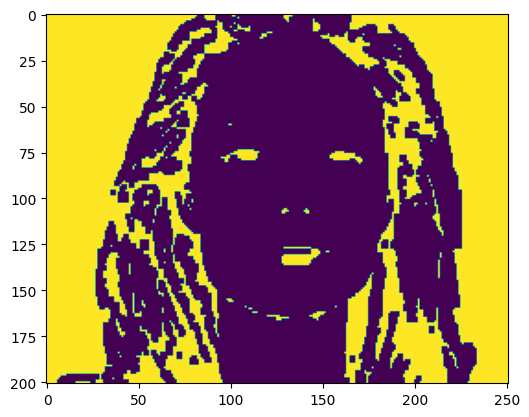

2


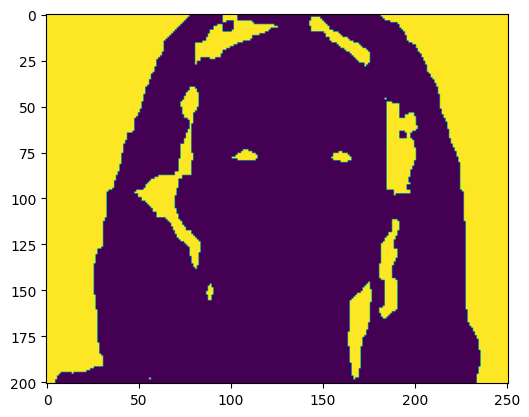

3


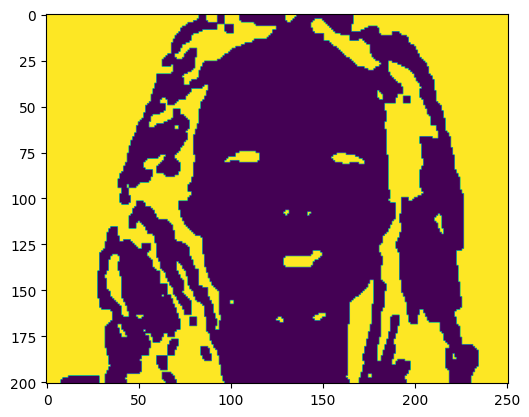

4


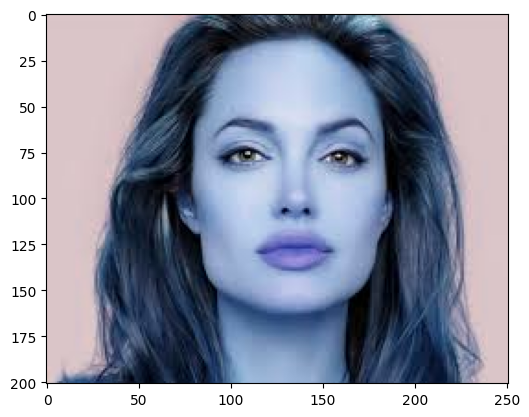

In [62]:
import cv2
import numpy as np

#Open a simple image
img =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/jolie.jpg")

#converting from gbr to hsv color space
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#skin color range for hsv color space
HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255))
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#converting from gbr to YCbCr color space
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#skin color range for hsv color space
YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#merge skin detection (YCbCr and hsv)
global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
global_mask=cv2.medianBlur(global_mask,3)
global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


HSV_result = cv2.bitwise_not(HSV_mask)
YCrCb_result = cv2.bitwise_not(YCrCb_mask)
global_result=cv2.bitwise_not(global_mask)


#show results
print(1)
plt.imshow(HSV_result)
plt.show()
print(2)
plt.imshow(YCrCb_result)
plt.show()
print(3)
plt.imshow(global_result)
plt.show()
print(4)
plt.imshow(img)
plt.show()


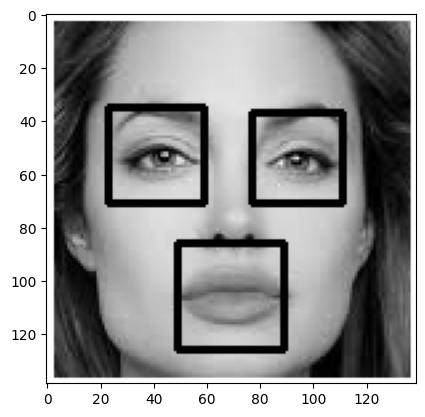

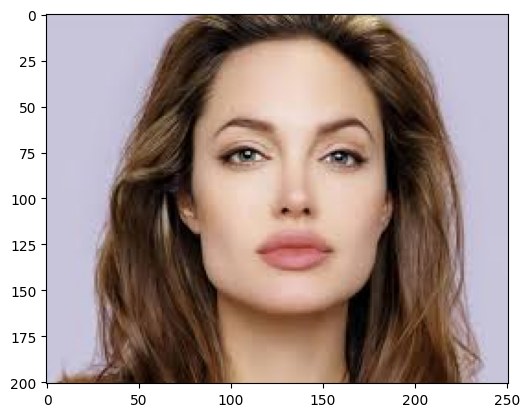

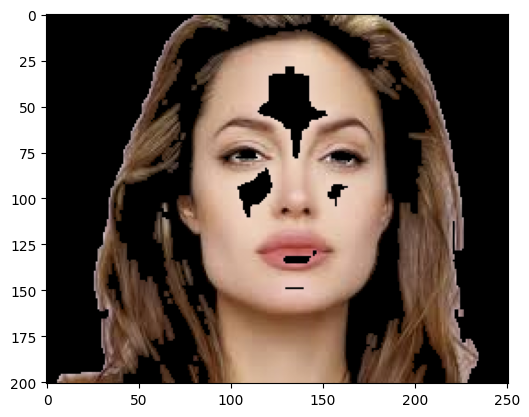

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 1,
 'color': [100.95202622169238, 69.37634088200227, 49.49016686531577],
 'color_percentage': 0.12495811147931637}

{'cluster_index': 7,
 'color': [80.3940307506783, 52.44256858607188, 34.263491106421256],
 'color_percentage': 0.12350597609561753}

{'cluster_index': 6,
 'color': [207.07169179229942, 168.7145728643207, 146.18961474037047],
 'color_percentage': 0.10958037010835164}

{'cluster_index': 5,
 'color': [121.31509236667887, 87.57441617288325, 66.91669571279138],
 'color_percentage': 0.1068250363033846}

{'cluster_index': 9,
 'color': [233.034913634698, 201.88533627342588, 183.35317897831894],
 'color_percentage': 0.1025058643928957}

{'cluster_index': 0,
 'color': [188.0863883847589, 149.154990925591, 129.28275862069137],
 'color_percentage': 0.10213352198681908}

{'cluster_index': 2,
 'color': [221.07397671799185, 184.83064213293142, 163.63424708975043],
 'color_percentage': 0.10012287299400528}

{'cluster_index': 8,
 'color': [168.922917530

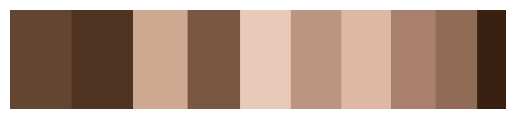

In [68]:

import dlib

# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
#
image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/jolie.jpg")

face = extractContour(image)
plt.imshow(face, cmap='gray')
plt.show()

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()



# Apply Skin Mask
skin = extractSkin(image)


plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()


# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin,hasThresholding=True)


#Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)


#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()


